In [ ]:
from scipy.stats import gamma, norm, poisson
from scipy.special import logsumexp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

This notebook contains code stubs and functions for you to fill out in order to complete Part 1 of HW3. Please copy and paste code from this document into your HW document as needed.

,Year,Count
0,1851,4
1,1852,5
2,1853,4
3,1854,1
4,1855,0


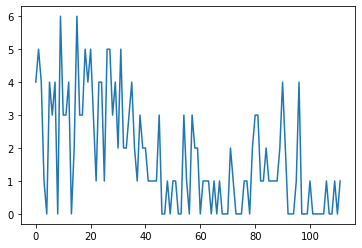

In [ ]:
#Import dataset
coal_dat = pd.read_csv("coaldisasters-ds6040.csv")
coal_dat['Count'].plot()
coal_dat.head()

The likelihood is 
\begin{align*}
    L(\textbf{X} | \mu, \lambda, k) 
    &= \prod_{i=1}^k p(x_j \mid \mu) \prod_{j=k+1}^{112} p(x_j \mid \lambda) \\
    &= \prod_{i=1}^k \frac{\mu^{X_i} e^{-\mu}}{X_i !}\prod_{j=k+1}^{112} \frac{\lambda^{X_j} e^{-\lambda}}{X_j !}
\end{align*}
Densities get small, though, so we should always write logic with the $\log$ of quantities.

\begin{align*}
    \log L(\textbf{X} | \mu, \lambda, k) 
    &= \sum_{i=1}^k \log p(x_i \mid \mu) + \sum_{j=k+1}^{112} \log p(x_j \mid \lambda) 
\end{align*}

We'll need this function later, so let's just define it now.


In [8]:
def log_like(x_data, mu, lamb, k):
    n = len(x_data)
    first_chunks = poisson.logpmf(x_data[0:k], mu) 
    second_chunks = poisson.logpmf(x_data[(k+1):n], lamb)
    return np.sum(first_chunks) + np.sum(second_chunks)

# example call
log_like(np.random.choice(4, size=3), 1, 2, 3)

-7.276666119016055

Below we will write a Gibbs sampler. Every iteration of the chain will do three things---it will sample from these distributions to "refresh" each of the three parameters

\begin{align*}
    \mu | \lambda, k &\sim \text{Gamma}(a_\mu + \sum_{i = 1}^k X_i, k + b_\mu) \tag{1} \\
    \lambda | \mu, k &\sim \text{Gamma}(a_\lambda +\sum_{i = k+1}^{112} X_i , 112 - k + b_\lambda) \tag{2} \\
    p(k = \hat{k} |\mu, \lambda) &= \frac{L(\textbf{X}|\mu, \lambda, \hat{k})}{\sum_{i = 1}^{112} L(\textbf{X}|\mu, \lambda, k = i)} \tag{3} 
\end{align*}

The first two have a built-in `scipy` function, but be careful of the parameterization. 



In [289]:
# example sampling from a gamma
# make sure you use the correct arguments
rate = 10
gamma.rvs(2, scale = 1/rate)

0.17453270999463982

The third equation (the third part of the iteration) is drawing a random index $k$. We need to write a function to define the weights on all the integers that $k$ can take on. Again, calculate the log of everything. 

\begin{align*}
    \log p(k = \hat{k} |\mu, \lambda) 
    &= \log L(\textbf{X}|\mu, \lambda, \hat{k})  - \log \sum_{i = 1}^{112} L(\textbf{X}|\mu, \lambda, k = i)
\end{align*}

To take the log of the denominator, use the famous **log-sum-exp** trick, which is implemented in `scipy.special.logsumexp()`. It's just a bit of algebra. 

\begin{align*}
    \log \sum_{i = 1}^{112} L(\textbf{X}|\mu, \lambda, k = i)
    &= \log \sum_{i = 1}^{112} \exp\left[ \log L(\textbf{X}|\mu, \lambda, k = i) \right] \\
    &= \log \sum_{i = 1}^{112} \exp\left[ \log L(\textbf{X}|\mu, \lambda, k = i) - m + m\right] \\
    &= m + \log \sum_{i = 1}^{112} \exp\left[ \log L(\textbf{X}|\mu, \lambda, k = i) - m \right] 
\end{align*}

where $m = \max_i L(\textbf{X}|\mu, \lambda, k = i)$. This clevery avoids exponentiating numbers that are close to negative infinity. 


In [290]:
def samp_k(x_data, mu, lamb):
    n = len(x_data)
    possible_ks = np.arange(n)
    log_unnorm_weights = ... # to do!
    log_denominator = logsumexp(log_unnorm_weights)
    log_norm_weights = log_unnorm_weights - log_denominator
    return np.random.choice(n, size=1, p=np.exp(log_norm_weights))[0]

#samp_k(coal_dat['Count'], 2, 2)

Now we can finally write a Gibbs sampler class. 

Note that we can't use Hamiltonian or NUTS to sample because a discrete parameter $k$. Those samplers assume all parameters are continuous random variables.

In [1]:
class CoalDisasterModel():
    """Gibbs Sampler"""
    def __init__(self, data, a_mu, b_mu, a_lambda, b_lambda, 
                 start_mu = 5, start_lambda = .1, start_k = 64, iter_num = 1000, burnin = 500):
        
        #Read in data and priors, and make them contained class variables
        self.data = data
        self.a_mu = a_mu
        self.b_mu = b_mu
        self.a_lambda = a_lambda
        self.b_lambda = b_lambda
        self.iter_num = iter_num
        self.burnin = burnin
        
        #Initalize sampling containers
        self.mu = np.zeros(iter_num+burnin+1)
        self.lambdap = np.zeros(iter_num+burnin+1)
        self.k = np.zeros(iter_num+burnin+1)
        
        #Put in starting values
        self.mu[0] = start_mu
        self.lambdap[0] = start_lambda
        self.k[0] = start_k     
        
        for i in np.arange(iter_num+burnin):
            if i % 100 == 0:
                print("Iteration " + str(i))
            
            
            #This is where you modify the sampler
            self.mu[i+1] =  gamma.rvs(a_mu + sum(data[:int(self.k[i])]), self.k[i] + b_mu)
            self.lambdap[i+1] = gamma.rvs(a_lambda + sum(data[int(self.k[i])+1:]), len(data) - self.k[i] + b_lambda)
            self.k[i+1] = samp_k(self.data, self.mu[i+1], self.lambdap[i+1])
            
    def plot_posteriors(self):
        f, axs = plt.subplots(3,2, figsize = (15, 7))
        f.tight_layout(pad = 3)
        sns.kdeplot(self.mu[self.burnin:],ax =axs[0,0])
        axs[0,0].set_xlabel(r'Posterior $\mu$')
        axs[0,0].set_ylabel('Probability Density')
        sns.kdeplot(self.lambdap[self.burnin:], ax =axs[1,0])
        axs[1,0].set_xlabel(r'Posterior $\lambda$')
        axs[1,0].set_ylabel('Probability Density')
        axs[2,0].hist(self.k[self.burnin:], bins = 112)
        axs[2,0].set_xlabel(r'Posterior k')
        axs[2,0].set_ylabel('Frequency')
        axs[0,1].plot(np.arange(self.iter_num+self.burnin+1),self.mu, '-')
        axs[0,1].set_xlabel('')
        axs[0,1].set_ylabel(r'Posterior $\mu$')
        axs[1,1].plot(np.arange(self.iter_num+self.burnin+1),self.lambdap,'-')
        axs[1,1].set_xlabel('')
        axs[1,1].set_ylabel(r'Posterior $\lambda$')
        axs[2,1].plot(np.arange(self.iter_num+self.burnin+1),self.k,'-')
        axs[2,1].set_xlabel('Iteration')
        axs[2,1].set_ylabel('Posterior k')
    
    def get_rate_estimates(self):
        to_return =pd.DataFrame(columns = ['Posterior EAP', 'Posterior Cred Interval Lower', 'Posterior Cred Interval Upper'])
        to_return.loc[r'mu', 'Posterior EAP'] = self.mu[self.burnin:].mean()
        to_return.loc[r'lambda', 'Posterior EAP'] = self.lambdap[self.burnin:].mean()
        to_return.loc[r'mu', 'Posterior Cred Interval Lower'] = np.quantile(self.mu[self.burnin:],.025)
        to_return.loc[r'lambda', 'Posterior Cred Interval Lower'] = np.quantile(self.lambdap[self.burnin:],.025)
        to_return.loc[r'mu', 'Posterior Cred Interval Upper'] = np.quantile(self.mu[self.burnin:],.975)
        to_return.loc[r'lambda', 'Posterior Cred Interval Upper'] = np.quantile(self.lambdap[self.burnin:],.975)
        return to_return
    
    def get_k_probs(self):
        freq = np.bincount(abs(self.k.astype('int'))[self.burnin:])
        ii = np.nonzero(freq)[0]
        freq = np.vstack((ii,freq[ii])).T
        freq = freq.astype("float16")
        freq[:,1] = freq[:,1]/(freq[:,1].sum())
        freq = pd.DataFrame(freq, columns=['k', 'Probability of k'])
        
        return freq

In [2]:
test = CoalDisasterModel(coal_dat['Count'], 1,1,1,1)

NameError: name 'coal_dat' is not defined

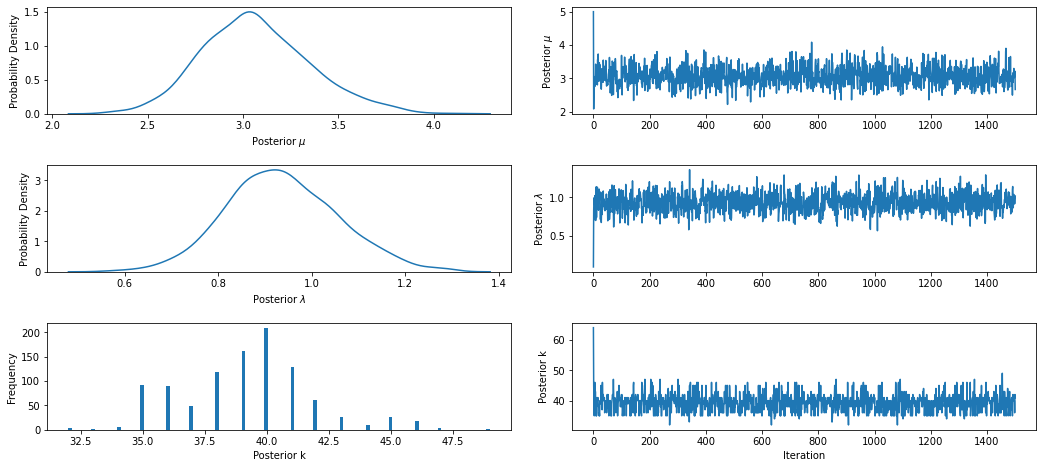

In [286]:
# look for the hairy caterpillars!
test.plot_posteriors()

In [291]:
test.get_rate_estimates()

,Posterior EAP,Posterior Cred Interval Lower,Posterior Cred Interval Upper
mu,3.068964,2.553408,3.672038
lambda,0.936335,0.709771,1.182965
